# Contrastive Representation Distillation Experiments
## Comparing Baseline SupCon vs Logit-Weighted SupCRD

**Goal**: Evaluate whether using teacher logits to weight contrastive forces improves student representation quality.

**Methods**:
- **Baseline**: Standard Supervised Contrastive Learning (SupCon)
- **Proposed**: Logit-Weighted Supervised Contrastive Representation Distillation (SupCRD)
  - Pull weight: `α × P_teacher(target_class)`
  - Push weight: `β × (1 - P_teacher(negative_class))`

---
## Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---
## Hyperparameters

In [2]:
# Training config
BATCH_SIZE = 128
LR = 1e-3
EPOCHS_TEACHER = 10
EPOCHS_STUDENT = 20  # Using 20 epochs for fair comparison

# Contrastive config
TEMP = 0.07

# Distillation config (for SupCRD)
ALPHA = 1.0  # Pull force weight
BETA = 10.0  # Push force weight

---
## Data Loading (CIFAR-10)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Train samples: 50000
Test samples: 10000


---
## Model Architecture

In [4]:
class ConvEncoder(nn.Module):
    """Simple CNN Encoder outputting a flat feature vector."""
    def __init__(self, feature_dim=128):
        super().__init__()
        # Input: 3 x 32 x 32
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # -> 8x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # -> 4x4
        )
        self.flat_dim = 128 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ModelWrapper(nn.Module):
    """Wraps Encoder, Projection Head, and Classifier."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = ConvEncoder(feature_dim=128)
        
        # Projection Head (for Contrastive Loss)
        self.projector = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64) 
        )
        
        # Classifier (for Teacher Supervision / Eval)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feats = self.encoder(x)       # (Batch, 128)
        proj = self.projector(feats)  # (Batch, 64)
        logits = self.classifier(feats) # (Batch, 10)
        return feats, proj, logits

---
## Loss Functions

In [5]:
class LogitWeightedSupCRDLoss(nn.Module):
    """
    Logit-Weighted Supervised Contrastive Representation Distillation.
    
    Uses teacher probabilities to weight contrastive forces:
    - Pull: α × P_teacher(target_class)
    - Push: β × (1 - P_teacher(negative_class))
    """
    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device

        # 1. Normalize features
        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)

        # 2. Similarity Matrix
        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)

        # 3. Teacher Probabilities
        teacher_probs = F.softmax(teacher_logits, dim=1)

        # 4. Construct Masks
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos

        # 5. Compute Weights
        # Pull weight
        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target
        
        # Push weight
        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        w_push = self.beta * (1.0 - p_negative_class)

        # 6. Compute Loss
        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp

        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        return loss.mean()


class SupConLoss(nn.Module):
    """BASELINE: Standard Supervised Contrastive Loss (Student vs Student)"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, student_proj, labels):
        feats = F.normalize(student_proj, dim=1)
        sim_matrix = torch.matmul(feats, feats.T) / self.temp
        
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        # Remove self-contrast
        logits_mask = torch.scatter(torch.ones_like(mask), 1, 
                                    torch.arange(feats.shape[0]).view(-1, 1).to(device), 0)
        mask = mask * logits_mask
        
        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - logits_max.detach()
        
        exp_logits = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()

---
## Visualization: t-SNE Latent Space

In [6]:
def visualize_latents(model, loader, title="Latent Space", save_path=None):
    """Runs t-SNE on model features and plots them."""
    model.eval()
    features_list = []
    labels_list = []
    num_samples = 2000
    count = 0
    
    print(f"[{title}] Extracting features...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats, _, _ = model(images)
            feats = feats.view(feats.size(0), -1).cpu()
            
            features_list.append(feats)
            labels_list.append(labels)
            
            count += images.size(0)
            if count >= num_samples:
                break

    X = torch.cat(features_list, dim=0).numpy()[:num_samples]
    y = torch.cat(labels_list, dim=0).numpy()[:num_samples]

    print(f"[{title}] Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    cifar_classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    sns.scatterplot(
        x=X_embedded[:, 0], y=X_embedded[:, 1], 
        hue=y, palette='tab10', legend='full', alpha=0.7
    )
    plt.legend(title='Classes', labels=cifar_classes, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"{title} (t-SNE)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    plt.show()

---
## Training Functions

In [7]:
def train_teacher(epochs=10):
    """Train teacher model with standard cross-entropy."""
    model = ModelWrapper(num_classes=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\n{'='*60}")
    print(f"TRAINING TEACHER MODEL ({epochs} epochs)")
    print(f"{'='*60}")
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            _, _, logits = model(images)
            loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        avg_loss = total_loss / len(train_loader)
        acc = 100. * correct / total
        print(f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.3f} | Acc={acc:.1f}%")
    
    print(f"\n✓ Teacher training complete: {acc:.1f}% accuracy\n")
    return model


def train_student(teacher_model, mode="supcon", epochs=20, alpha=1.0, beta=1.0, temperature=0.07):
    """
    Train student with contrastive loss.
    
    Args:
        mode: 'supcon' (baseline) or 'supcrd' (logit-weighted)
    """
    student = ModelWrapper(num_classes=10).to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=LR)
    
    # Online Linear Probe
    probe_head = nn.Linear(128, 10).to(device) 
    probe_opt = torch.optim.Adam(probe_head.parameters(), lr=LR)
    probe_crit = nn.CrossEntropyLoss()

    # Select loss
    if mode == "supcrd":
        criterion = LogitWeightedSupCRDLoss(alpha=alpha, beta=beta, temperature=temperature)
        print(f"\n{'='*60}")
        print(f"TRAINING: Logit-Weighted SupCRD")
        print(f"α={alpha} (pull) | β={beta} (push) | τ={temperature}")
        print(f"{'='*60}\n")
    else:
        criterion = SupConLoss(temperature=temperature)
        print(f"\n{'='*60}")
        print(f"TRAINING: Baseline SupCon")
        print(f"τ={temperature}")
        print(f"{'='*60}\n")

    training_log = {
        'epochs': [],
        'loss': [],
        'probe_acc': []
    }

    for epoch in range(epochs):
        student.train()
        probe_head.train()
        total_loss = 0
        probe_acc = 0
        total_samples = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward Student
            s_feats, s_proj, _ = student(images)
            
            # Compute Loss
            if mode == "supcrd":
                with torch.no_grad():
                    _, t_proj, t_logits = teacher_model(images)
                loss = criterion(s_proj, t_proj, t_logits, labels)
            else:
                loss = criterion(s_proj, labels)

            # Optimize Student
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Optimize Linear Probe
            probe_logits = probe_head(s_feats.detach()) 
            p_loss = probe_crit(probe_logits, labels)
            
            probe_opt.zero_grad()
            p_loss.backward()
            probe_opt.step()
            
            total_loss += loss.item()
            _, preds = probe_logits.max(1)
            probe_acc += preds.eq(labels).sum().item()
            total_samples += labels.size(0)
            
        avg_loss = total_loss / len(train_loader)
        avg_acc = 100. * probe_acc / total_samples
        
        training_log['epochs'].append(epoch + 1)
        training_log['loss'].append(avg_loss)
        training_log['probe_acc'].append(avg_acc)
        
        print(f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.4f} | Probe Acc={avg_acc:.2f}%")
    
    print(f"\n✓ Student training complete: {avg_acc:.2f}% accuracy\n")
    return student, training_log

---
---
# EXPERIMENTS
---

## Experiment 0: Train Teacher Model


TRAINING TEACHER MODEL (10 epochs)
Epoch  1/10: Loss=1.405 | Acc=49.3%
Epoch  2/10: Loss=1.001 | Acc=64.6%
Epoch  3/10: Loss=0.826 | Acc=71.1%
Epoch  4/10: Loss=0.718 | Acc=75.0%
Epoch  5/10: Loss=0.630 | Acc=78.0%
Epoch  6/10: Loss=0.553 | Acc=80.7%
Epoch  7/10: Loss=0.489 | Acc=82.7%
Epoch  8/10: Loss=0.434 | Acc=84.7%
Epoch  9/10: Loss=0.377 | Acc=86.6%
Epoch 10/10: Loss=0.334 | Acc=88.2%

✓ Teacher training complete: 88.2% accuracy

[Teacher Model] Extracting features...
[Teacher Model] Running t-SNE...
Saved plot to teacher_latent.png


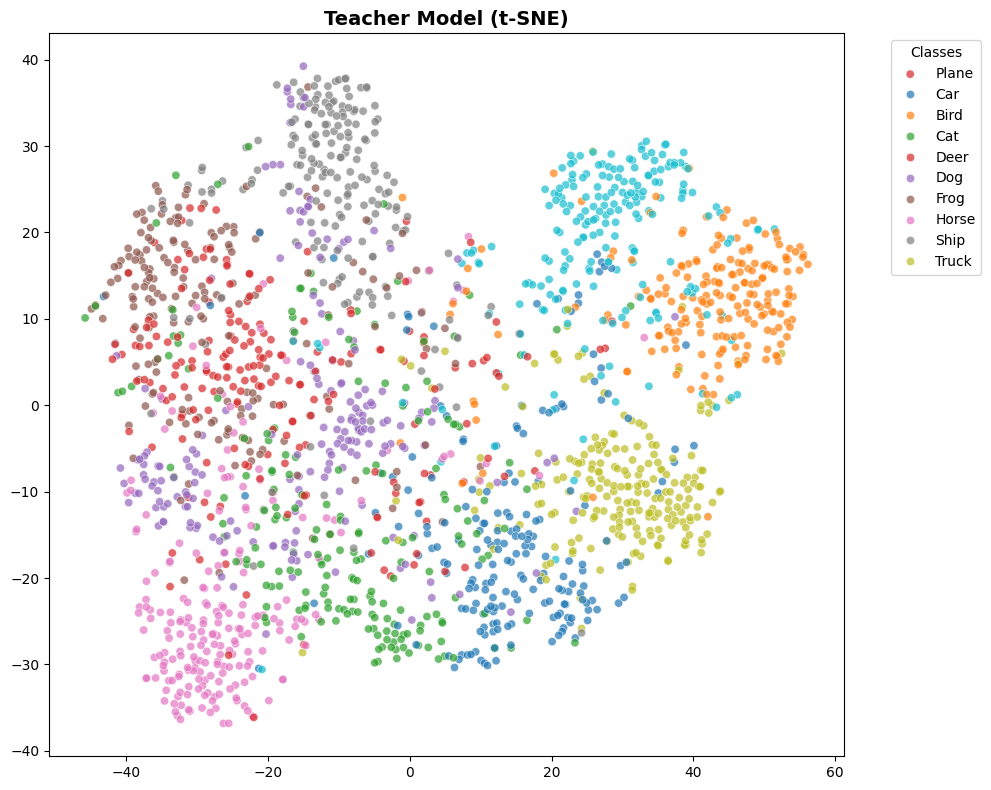

In [8]:
teacher = train_teacher(epochs=EPOCHS_TEACHER)
teacher.eval()

# Visualize teacher's latent space
visualize_latents(teacher, test_loader, 
                  title="Teacher Model",
                  save_path="teacher_latent.png")

---
## Experiment 1: Baseline SupCon (Student vs Student)


TRAINING: Baseline SupCon
τ=0.07

Epoch  1/20: Loss=4.3892 | Probe Acc=37.57%
Epoch  2/20: Loss=4.0582 | Probe Acc=59.51%
Epoch  3/20: Loss=3.8597 | Probe Acc=68.05%
Epoch  4/20: Loss=3.7093 | Probe Acc=73.60%
Epoch  5/20: Loss=3.5948 | Probe Acc=76.92%
Epoch  6/20: Loss=3.5032 | Probe Acc=79.18%
Epoch  7/20: Loss=3.4218 | Probe Acc=81.21%
Epoch  8/20: Loss=3.3435 | Probe Acc=82.91%
Epoch  9/20: Loss=3.2583 | Probe Acc=84.53%
Epoch 10/20: Loss=3.2210 | Probe Acc=85.37%
Epoch 11/20: Loss=3.1551 | Probe Acc=86.76%
Epoch 12/20: Loss=3.1218 | Probe Acc=87.14%
Epoch 13/20: Loss=3.0716 | Probe Acc=87.85%
Epoch 14/20: Loss=3.0237 | Probe Acc=88.92%
Epoch 15/20: Loss=2.9843 | Probe Acc=89.45%
Epoch 16/20: Loss=2.9578 | Probe Acc=89.76%
Epoch 17/20: Loss=2.9391 | Probe Acc=90.10%
Epoch 18/20: Loss=2.8974 | Probe Acc=90.81%
Epoch 19/20: Loss=2.8746 | Probe Acc=91.11%
Epoch 20/20: Loss=2.8559 | Probe Acc=91.30%

✓ Student training complete: 91.30% accuracy

[Baseline SupCon] Extracting features.

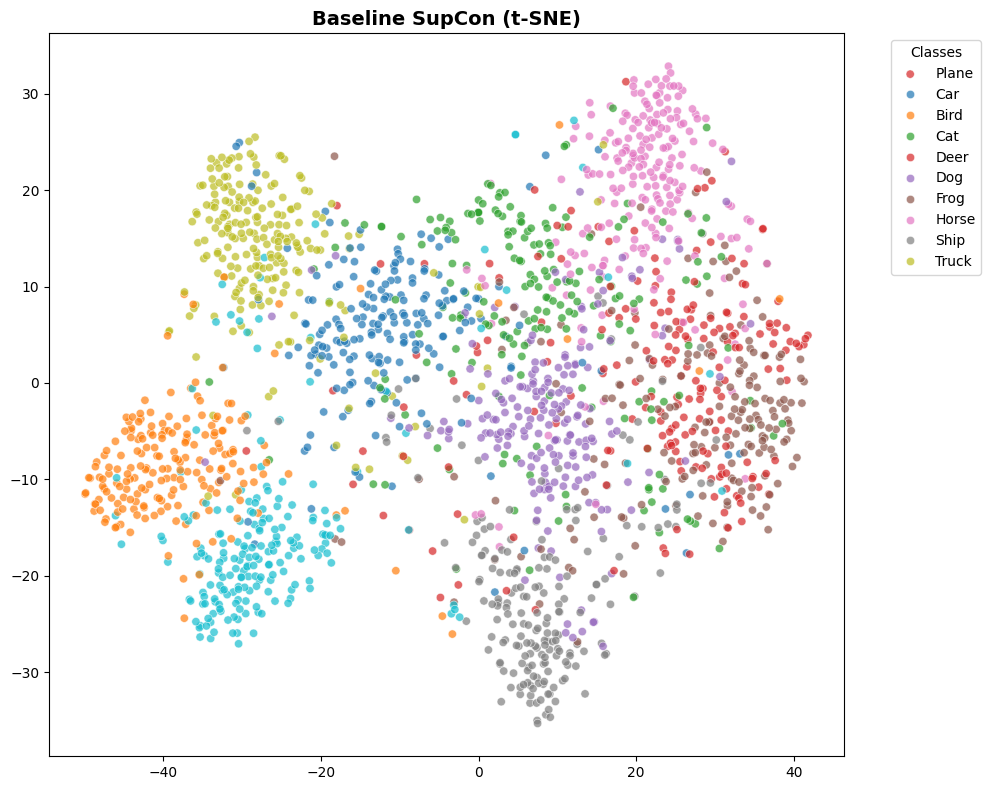

In [9]:
baseline_student, baseline_log = train_student(
    teacher_model=teacher,
    mode="supcon",
    epochs=EPOCHS_STUDENT,
    temperature=TEMP
)

visualize_latents(baseline_student, test_loader,
                  title="Baseline SupCon",
                  save_path="baseline_supcon_latent.png")

---
## Experiment 2: Logit-Weighted SupCRD (α=1.0, β=10.0, τ=0.07)


TRAINING: Logit-Weighted SupCRD
α=1.0 (pull) | β=10.0 (push) | τ=0.07

Epoch  1/20: Loss=3.1489 | Probe Acc=45.33%
Epoch  2/20: Loss=2.1314 | Probe Acc=65.87%
Epoch  3/20: Loss=1.7831 | Probe Acc=72.27%
Epoch  4/20: Loss=1.6031 | Probe Acc=75.25%
Epoch  5/20: Loss=1.4968 | Probe Acc=77.40%
Epoch  6/20: Loss=1.4077 | Probe Acc=79.22%
Epoch  7/20: Loss=1.3285 | Probe Acc=80.52%
Epoch  8/20: Loss=1.2745 | Probe Acc=81.57%
Epoch  9/20: Loss=1.2340 | Probe Acc=82.48%
Epoch 10/20: Loss=1.1830 | Probe Acc=83.33%
Epoch 11/20: Loss=1.1391 | Probe Acc=83.88%
Epoch 12/20: Loss=1.1219 | Probe Acc=84.39%
Epoch 13/20: Loss=1.0622 | Probe Acc=85.33%
Epoch 14/20: Loss=1.0396 | Probe Acc=85.68%
Epoch 15/20: Loss=1.0219 | Probe Acc=86.21%
Epoch 16/20: Loss=1.0015 | Probe Acc=86.37%
Epoch 17/20: Loss=0.9679 | Probe Acc=86.97%
Epoch 18/20: Loss=0.9437 | Probe Acc=87.24%
Epoch 19/20: Loss=0.9264 | Probe Acc=87.49%
Epoch 20/20: Loss=0.9204 | Probe Acc=87.67%

✓ Student training complete: 87.67% accuracy

[

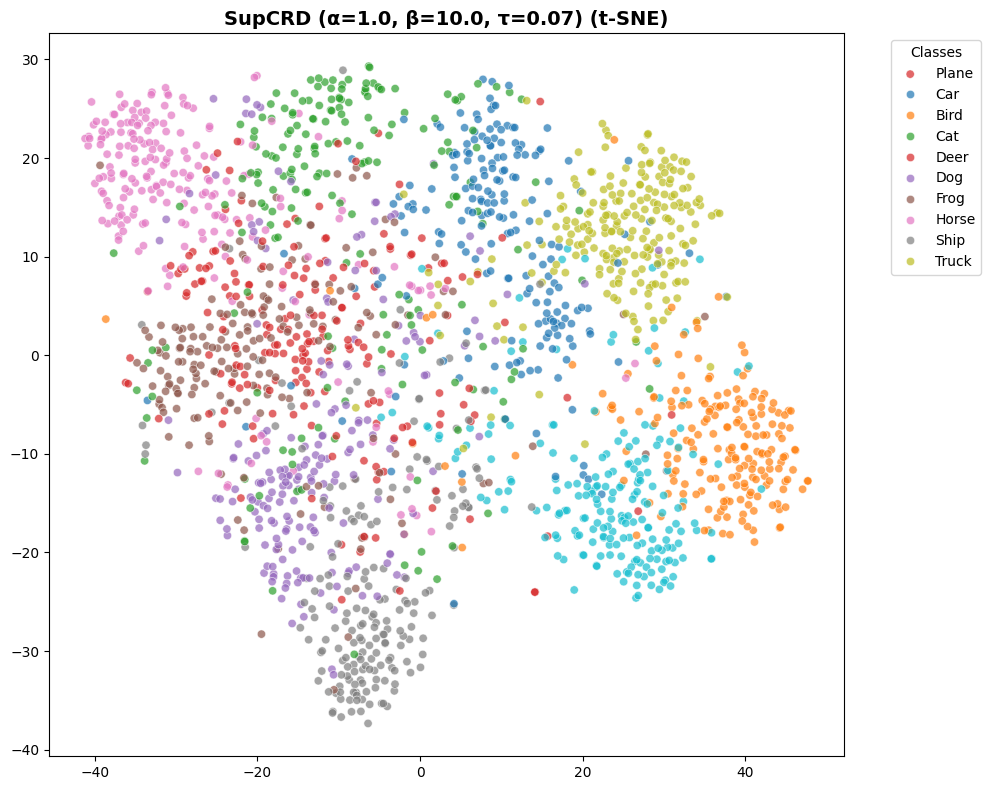

In [10]:
supcrd_student_1, supcrd_log_1 = train_student(
    teacher_model=teacher,
    mode="supcrd",
    epochs=EPOCHS_STUDENT,
    alpha=1.0,
    beta=10.0,
    temperature=0.07
)

visualize_latents(supcrd_student_1, test_loader,
                  title="SupCRD (α=1.0, β=10.0, τ=0.07)",
                  save_path="supcrd_a1_b10_t007_latent.png")

---
## Experiment 3: Logit-Weighted SupCRD (α=1.0, β=10.0, τ=0.007)


TRAINING: Logit-Weighted SupCRD
α=1.0 (pull) | β=10.0 (push) | τ=0.007

Epoch  1/20: Loss=6.6767 | Probe Acc=22.13%
Epoch  2/20: Loss=3.9918 | Probe Acc=42.86%
Epoch  3/20: Loss=2.8383 | Probe Acc=56.83%
Epoch  4/20: Loss=1.9972 | Probe Acc=65.10%
Epoch  5/20: Loss=1.4327 | Probe Acc=69.78%
Epoch  6/20: Loss=1.0949 | Probe Acc=72.72%
Epoch  7/20: Loss=0.8871 | Probe Acc=73.90%
Epoch  8/20: Loss=0.7127 | Probe Acc=75.43%
Epoch  9/20: Loss=0.6269 | Probe Acc=75.77%
Epoch 10/20: Loss=0.5397 | Probe Acc=76.42%
Epoch 11/20: Loss=0.4867 | Probe Acc=77.07%
Epoch 12/20: Loss=0.4322 | Probe Acc=77.34%
Epoch 13/20: Loss=0.3816 | Probe Acc=77.86%
Epoch 14/20: Loss=0.3608 | Probe Acc=77.89%
Epoch 15/20: Loss=0.3314 | Probe Acc=78.24%
Epoch 16/20: Loss=0.3069 | Probe Acc=78.60%
Epoch 17/20: Loss=0.2844 | Probe Acc=78.88%
Epoch 18/20: Loss=0.2569 | Probe Acc=79.00%
Epoch 19/20: Loss=0.2536 | Probe Acc=79.04%
Epoch 20/20: Loss=0.2389 | Probe Acc=79.30%

✓ Student training complete: 79.30% accuracy



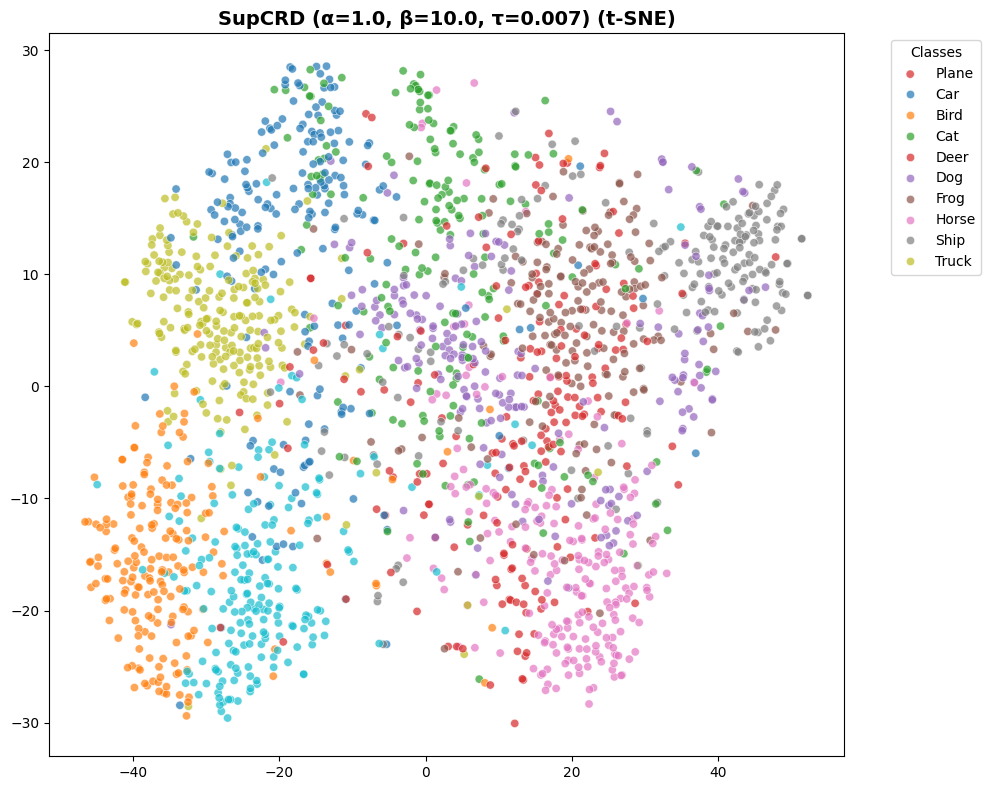

In [11]:
supcrd_student_2, supcrd_log_2 = train_student(
    teacher_model=teacher,
    mode="supcrd",
    epochs=EPOCHS_STUDENT,
    alpha=1.0,
    beta=10.0,
    temperature=0.007
)

visualize_latents(supcrd_student_2, test_loader,
                  title="SupCRD (α=1.0, β=10.0, τ=0.007)",
                  save_path="supcrd_a1_b10_t0007_latent.png")

---
## Experiment 4: Alpha Sweep (β=1.0, τ=0.07)


############################################################
Alpha Sweep: α=1.0
############################################################

TRAINING: Logit-Weighted SupCRD
α=1.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=1.4267 | Probe Acc=45.96%
Epoch  2/20: Loss=0.8134 | Probe Acc=66.46%
Epoch  3/20: Loss=0.6473 | Probe Acc=72.44%
Epoch  4/20: Loss=0.5653 | Probe Acc=75.66%
Epoch  5/20: Loss=0.5049 | Probe Acc=77.68%
Epoch  6/20: Loss=0.4699 | Probe Acc=79.09%
Epoch  7/20: Loss=0.4439 | Probe Acc=80.44%
Epoch  8/20: Loss=0.4140 | Probe Acc=81.58%
Epoch  9/20: Loss=0.3894 | Probe Acc=82.62%
Epoch 10/20: Loss=0.3723 | Probe Acc=83.47%
Epoch 11/20: Loss=0.3548 | Probe Acc=83.98%
Epoch 12/20: Loss=0.3378 | Probe Acc=85.04%
Epoch 13/20: Loss=0.3208 | Probe Acc=85.83%
Epoch 14/20: Loss=0.3133 | Probe Acc=86.23%
Epoch 15/20: Loss=0.2980 | Probe Acc=86.78%
Epoch 16/20: Loss=0.2871 | Probe Acc=87.24%
Epoch 17/20: Loss=0.2783 | Probe Acc=87.72%
Epoch 18/20: Loss=0.2640 | Probe Acc=88

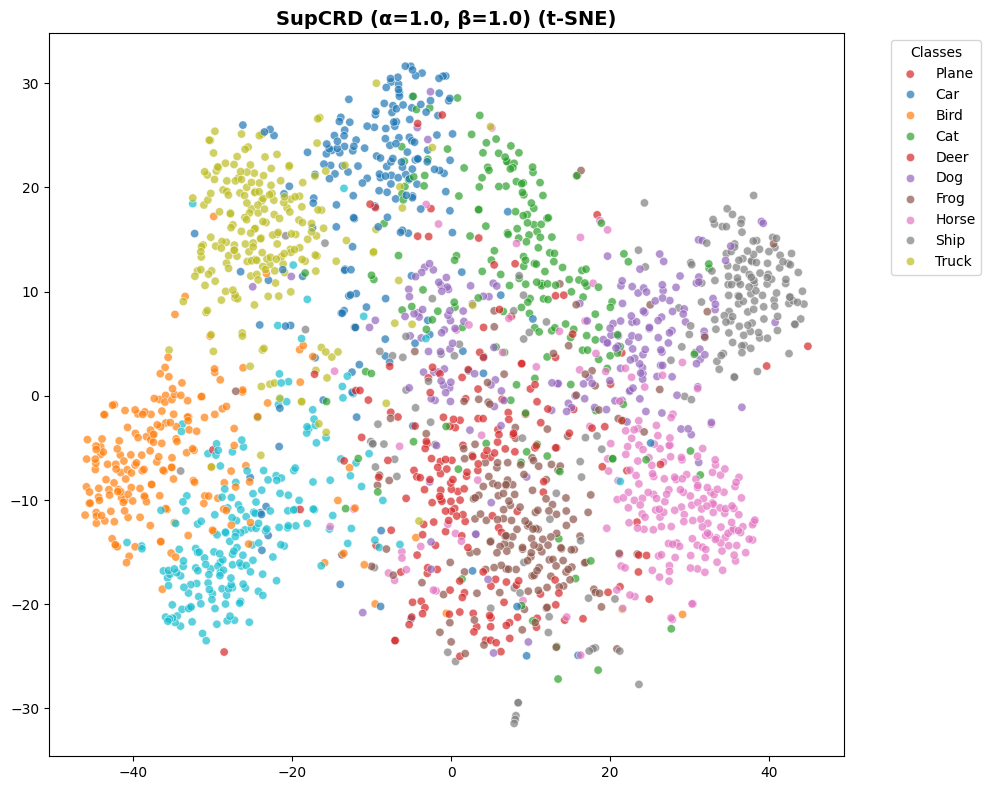


############################################################
Alpha Sweep: α=10.0
############################################################

TRAINING: Logit-Weighted SupCRD
α=10.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=0.4592 | Probe Acc=39.96%
Epoch  2/20: Loss=0.2852 | Probe Acc=59.00%
Epoch  3/20: Loss=0.2083 | Probe Acc=66.05%
Epoch  4/20: Loss=0.1714 | Probe Acc=69.61%
Epoch  5/20: Loss=0.1467 | Probe Acc=72.11%
Epoch  6/20: Loss=0.1297 | Probe Acc=73.64%
Epoch  7/20: Loss=0.1188 | Probe Acc=74.91%
Epoch  8/20: Loss=0.1075 | Probe Acc=75.95%
Epoch  9/20: Loss=0.1013 | Probe Acc=76.88%
Epoch 10/20: Loss=0.0936 | Probe Acc=77.68%
Epoch 11/20: Loss=0.0891 | Probe Acc=78.34%
Epoch 12/20: Loss=0.0836 | Probe Acc=79.23%
Epoch 13/20: Loss=0.0804 | Probe Acc=79.96%
Epoch 14/20: Loss=0.0773 | Probe Acc=80.34%
Epoch 15/20: Loss=0.0739 | Probe Acc=81.12%
Epoch 16/20: Loss=0.0692 | Probe Acc=81.59%
Epoch 17/20: Loss=0.0639 | Probe Acc=82.52%
Epoch 18/20: Loss=0.0655 | Probe Acc=

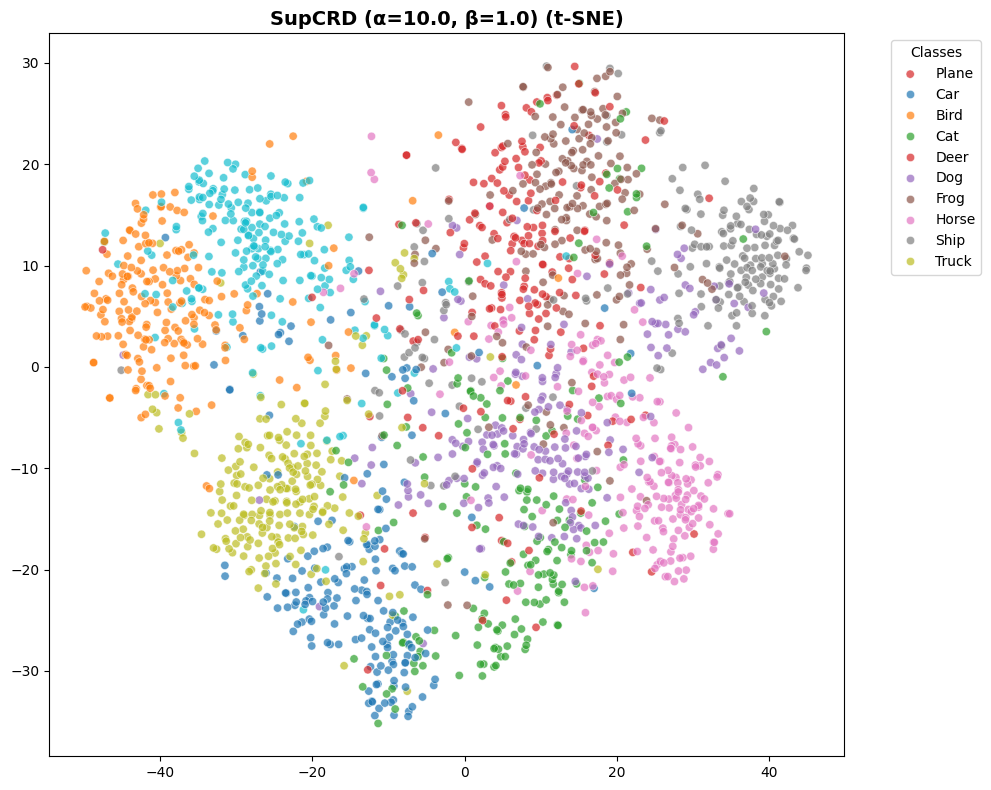


############################################################
Alpha Sweep: α=50.0
############################################################

TRAINING: Logit-Weighted SupCRD
α=50.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=0.1424 | Probe Acc=38.61%
Epoch  2/20: Loss=0.0954 | Probe Acc=56.58%
Epoch  3/20: Loss=0.0701 | Probe Acc=63.65%
Epoch  4/20: Loss=0.0544 | Probe Acc=67.54%
Epoch  5/20: Loss=0.0450 | Probe Acc=69.75%
Epoch  6/20: Loss=0.0385 | Probe Acc=72.04%
Epoch  7/20: Loss=0.0334 | Probe Acc=73.58%
Epoch  8/20: Loss=0.0298 | Probe Acc=74.89%
Epoch  9/20: Loss=0.0284 | Probe Acc=75.61%
Epoch 10/20: Loss=0.0260 | Probe Acc=76.53%
Epoch 11/20: Loss=0.0230 | Probe Acc=77.89%
Epoch 12/20: Loss=0.0221 | Probe Acc=78.39%
Epoch 13/20: Loss=0.0214 | Probe Acc=78.81%
Epoch 14/20: Loss=0.0202 | Probe Acc=79.67%
Epoch 15/20: Loss=0.0199 | Probe Acc=79.90%
Epoch 16/20: Loss=0.0194 | Probe Acc=80.19%
Epoch 17/20: Loss=0.0174 | Probe Acc=81.35%
Epoch 18/20: Loss=0.0166 | Probe Acc=

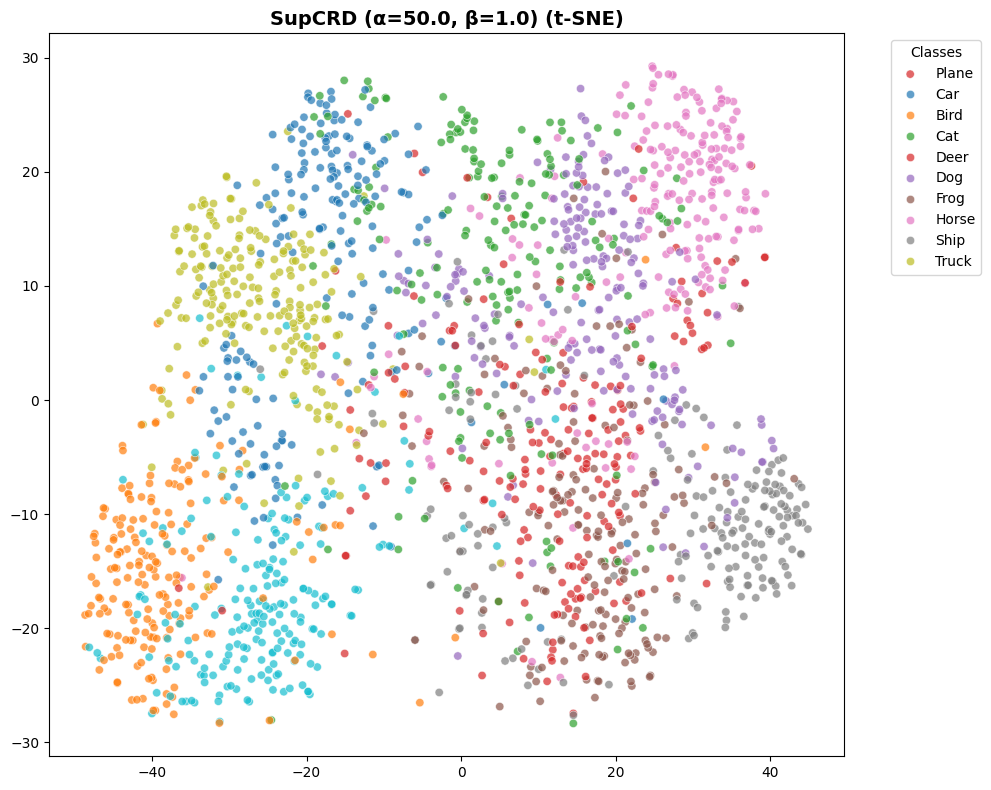

In [12]:
alpha_sweep_results = {}

for alpha in [1.0, 10.0, 50.0]:
    print(f"\n{'#'*60}")
    print(f"Alpha Sweep: α={alpha}")
    print(f"{'#'*60}")
    
    student, log = train_student(
        teacher_model=teacher,
        mode="supcrd",
        epochs=EPOCHS_STUDENT,
        alpha=alpha,
        beta=1.0,
        temperature=0.07
    )
    
    alpha_sweep_results[f"alpha_{alpha}"] = {
        'model': student,
        'log': log
    }
    
    visualize_latents(student, test_loader,
                      title=f"SupCRD (α={alpha}, β=1.0)",
                      save_path=f"supcrd_a{int(alpha)}_b1_latent.png")

---
## Experiment 5: Beta Sweep (α=1.0, τ=0.07)


############################################################
Beta Sweep: β=1.0
############################################################

TRAINING: Logit-Weighted SupCRD
α=1.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=1.3599 | Probe Acc=47.06%
Epoch  2/20: Loss=0.7858 | Probe Acc=68.08%
Epoch  3/20: Loss=0.6201 | Probe Acc=73.82%
Epoch  4/20: Loss=0.5423 | Probe Acc=77.01%
Epoch  5/20: Loss=0.4798 | Probe Acc=78.88%
Epoch  6/20: Loss=0.4423 | Probe Acc=80.64%
Epoch  7/20: Loss=0.4166 | Probe Acc=81.86%
Epoch  8/20: Loss=0.3857 | Probe Acc=83.19%
Epoch  9/20: Loss=0.3680 | Probe Acc=84.20%
Epoch 10/20: Loss=0.3498 | Probe Acc=84.91%
Epoch 11/20: Loss=0.3300 | Probe Acc=85.93%
Epoch 12/20: Loss=0.3126 | Probe Acc=86.73%
Epoch 13/20: Loss=0.3075 | Probe Acc=87.10%
Epoch 14/20: Loss=0.2891 | Probe Acc=88.05%
Epoch 15/20: Loss=0.2826 | Probe Acc=88.35%
Epoch 16/20: Loss=0.2660 | Probe Acc=89.09%
Epoch 17/20: Loss=0.2586 | Probe Acc=89.53%
Epoch 18/20: Loss=0.2566 | Probe Acc=89.

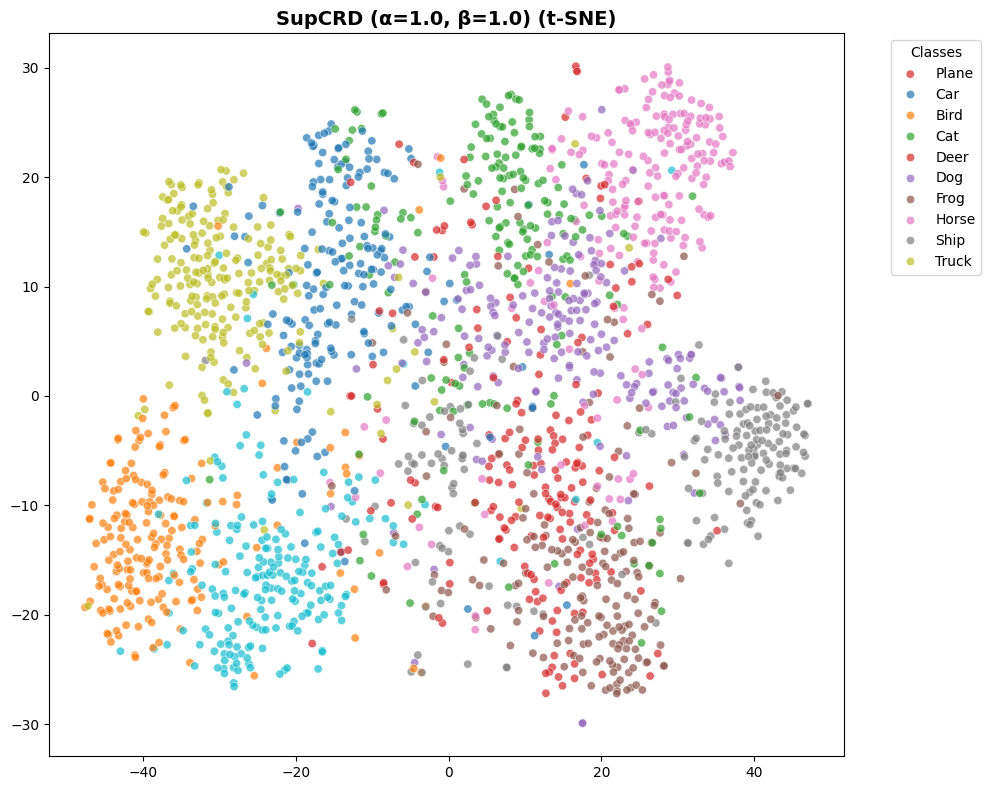


############################################################
Beta Sweep: β=10.0
############################################################

TRAINING: Logit-Weighted SupCRD
α=1.0 (pull) | β=10.0 (push) | τ=0.07

Epoch  1/20: Loss=3.1817 | Probe Acc=44.80%
Epoch  2/20: Loss=2.1276 | Probe Acc=66.07%
Epoch  3/20: Loss=1.7808 | Probe Acc=72.22%
Epoch  4/20: Loss=1.6093 | Probe Acc=75.48%
Epoch  5/20: Loss=1.4868 | Probe Acc=77.78%
Epoch  6/20: Loss=1.4005 | Probe Acc=79.53%
Epoch  7/20: Loss=1.3274 | Probe Acc=80.93%
Epoch  8/20: Loss=1.2654 | Probe Acc=81.92%
Epoch  9/20: Loss=1.2237 | Probe Acc=82.87%
Epoch 10/20: Loss=1.1739 | Probe Acc=83.71%
Epoch 11/20: Loss=1.1357 | Probe Acc=84.45%
Epoch 12/20: Loss=1.1040 | Probe Acc=85.06%
Epoch 13/20: Loss=1.0828 | Probe Acc=85.30%
Epoch 14/20: Loss=1.0321 | Probe Acc=86.20%
Epoch 15/20: Loss=1.0150 | Probe Acc=86.65%
Epoch 16/20: Loss=0.9832 | Probe Acc=87.15%
Epoch 17/20: Loss=0.9535 | Probe Acc=87.58%
Epoch 18/20: Loss=0.9379 | Probe Acc=8

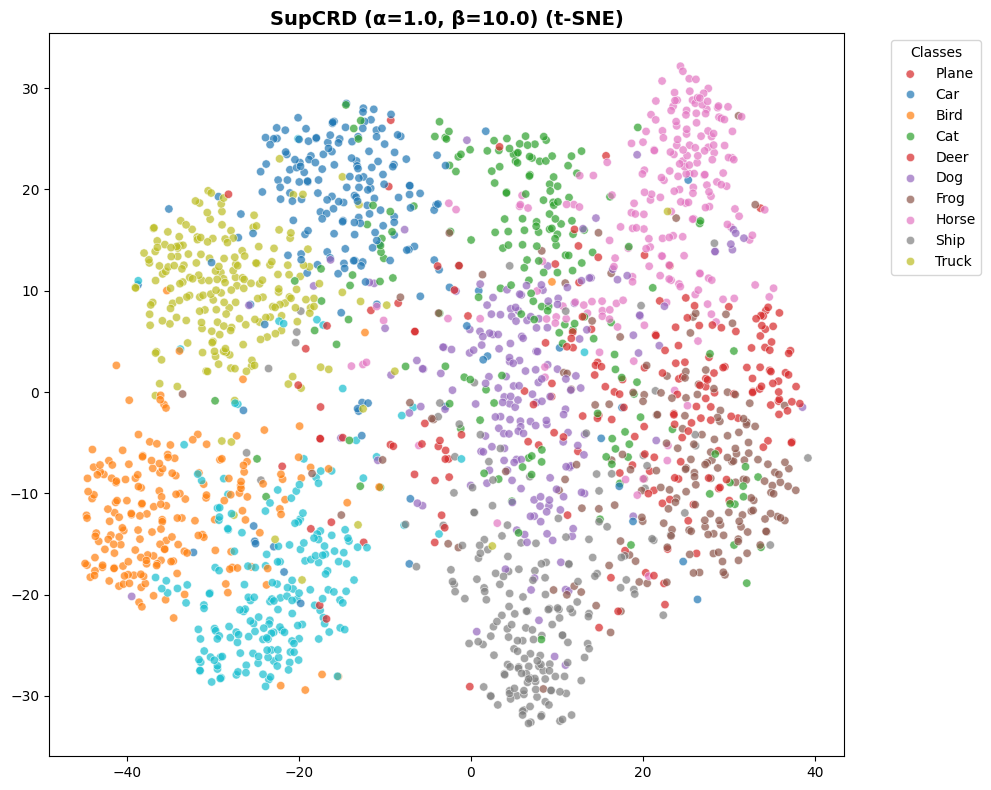


############################################################
Beta Sweep: β=50.0
############################################################

TRAINING: Logit-Weighted SupCRD
α=1.0 (pull) | β=50.0 (push) | τ=0.07

Epoch  1/20: Loss=4.4316 | Probe Acc=47.25%
Epoch  2/20: Loss=3.2151 | Probe Acc=66.81%
Epoch  3/20: Loss=2.8238 | Probe Acc=72.84%
Epoch  4/20: Loss=2.6074 | Probe Acc=75.74%
Epoch  5/20: Loss=2.4570 | Probe Acc=78.07%
Epoch  6/20: Loss=2.3430 | Probe Acc=79.78%
Epoch  7/20: Loss=2.2609 | Probe Acc=81.08%
Epoch  8/20: Loss=2.1734 | Probe Acc=82.40%
Epoch  9/20: Loss=2.1220 | Probe Acc=83.18%
Epoch 10/20: Loss=2.0556 | Probe Acc=84.07%
Epoch 11/20: Loss=1.9954 | Probe Acc=84.83%
Epoch 12/20: Loss=1.9648 | Probe Acc=85.24%
Epoch 13/20: Loss=1.9026 | Probe Acc=86.23%
Epoch 14/20: Loss=1.8692 | Probe Acc=86.70%
Epoch 15/20: Loss=1.8340 | Probe Acc=87.25%
Epoch 16/20: Loss=1.8008 | Probe Acc=87.65%
Epoch 17/20: Loss=1.7860 | Probe Acc=87.74%
Epoch 18/20: Loss=1.7531 | Probe Acc=8

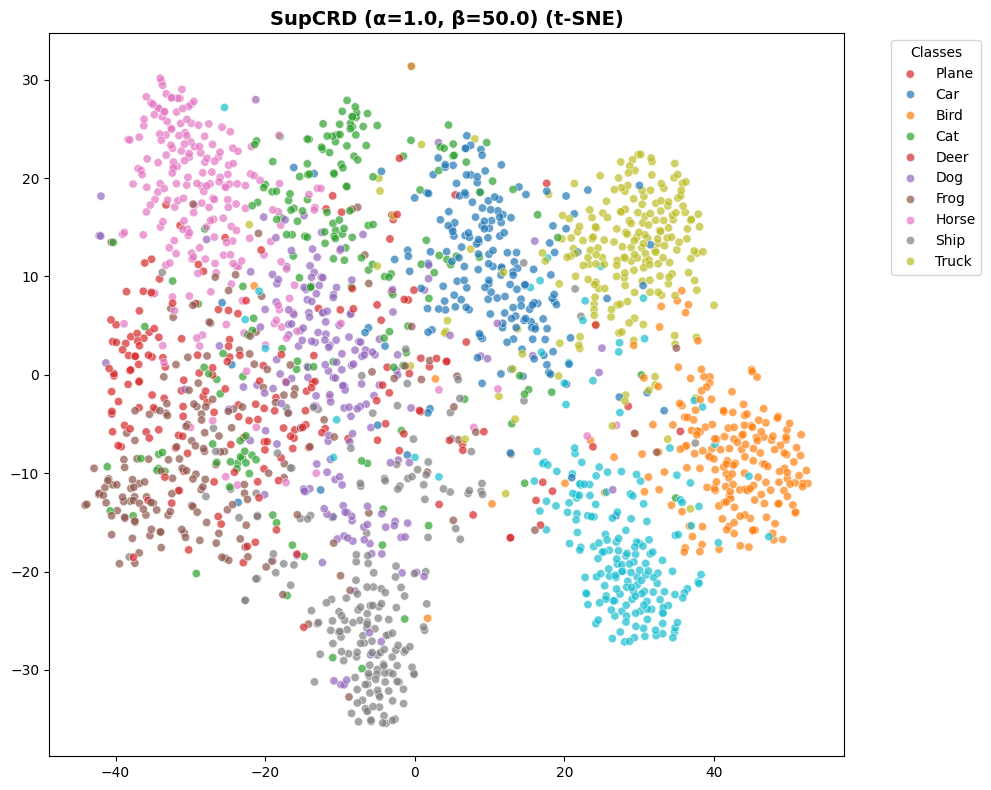

In [13]:
beta_sweep_results = {}

for beta in [1.0, 10.0, 50.0]:
    print(f"\n{'#'*60}")
    print(f"Beta Sweep: β={beta}")
    print(f"{'#'*60}")
    
    student, log = train_student(
        teacher_model=teacher,
        mode="supcrd",
        epochs=EPOCHS_STUDENT,
        alpha=1.0,
        beta=beta,
        temperature=0.07
    )
    
    beta_sweep_results[f"beta_{beta}"] = {
        'model': student,
        'log': log
    }
    
    visualize_latents(student, test_loader,
                      title=f"SupCRD (α=1.0, β={beta})",
                      save_path=f"supcrd_a1_b{int(beta)}_latent.png")

---
---
# RESULTS & ANALYSIS
---

## Training Curves Comparison

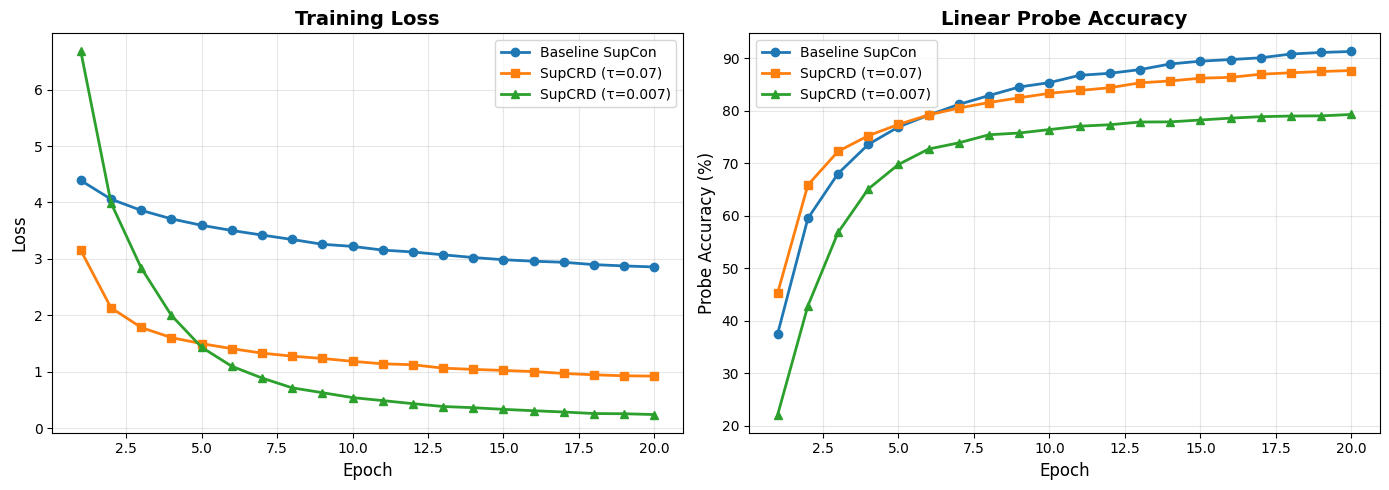

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(baseline_log['epochs'], baseline_log['loss'], 'o-', label='Baseline SupCon', linewidth=2)
ax1.plot(supcrd_log_1['epochs'], supcrd_log_1['loss'], 's-', label='SupCRD (τ=0.07)', linewidth=2)
ax1.plot(supcrd_log_2['epochs'], supcrd_log_2['loss'], '^-', label='SupCRD (τ=0.007)', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(baseline_log['epochs'], baseline_log['probe_acc'], 'o-', label='Baseline SupCon', linewidth=2)
ax2.plot(supcrd_log_1['epochs'], supcrd_log_1['probe_acc'], 's-', label='SupCRD (τ=0.07)', linewidth=2)
ax2.plot(supcrd_log_2['epochs'], supcrd_log_2['probe_acc'], '^-', label='SupCRD (τ=0.007)', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Probe Accuracy (%)', fontsize=12)
ax2.set_title('Linear Probe Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Alpha Sweep Results

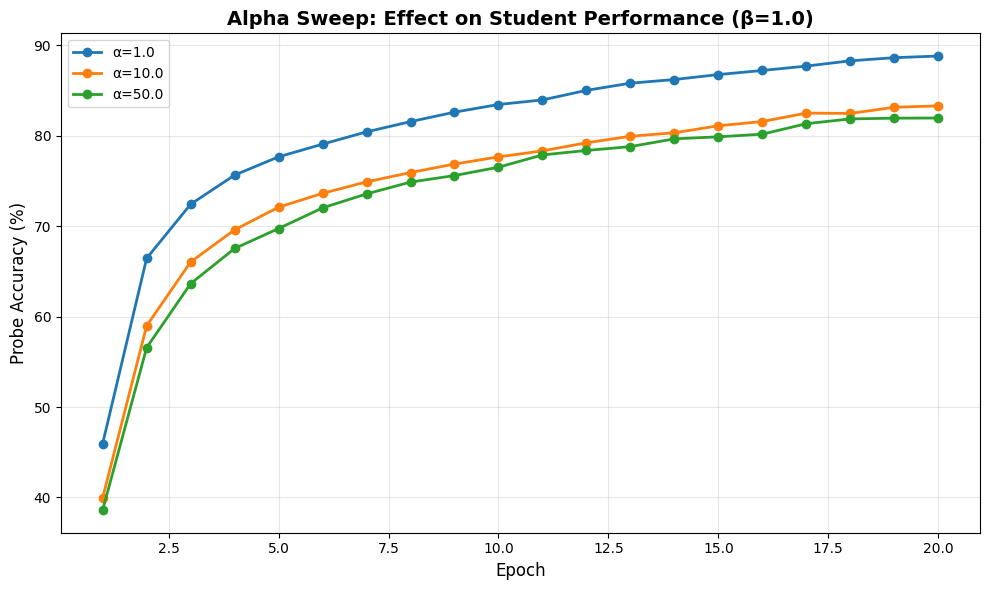

In [15]:
plt.figure(figsize=(10, 6))

for name, data in alpha_sweep_results.items():
    alpha_val = name.split('_')[1]
    plt.plot(data['log']['epochs'], data['log']['probe_acc'], 
             'o-', label=f'α={alpha_val}', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Probe Accuracy (%)', fontsize=12)
plt.title('Alpha Sweep: Effect on Student Performance (β=1.0)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('alpha_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## Beta Sweep Results

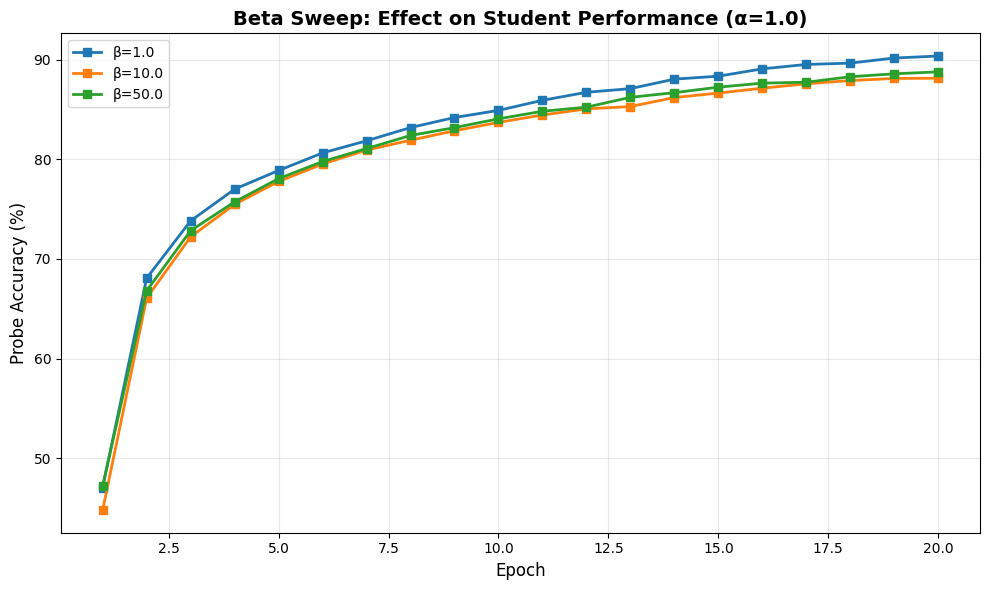

In [16]:
plt.figure(figsize=(10, 6))

for name, data in beta_sweep_results.items():
    beta_val = name.split('_')[1]
    plt.plot(data['log']['epochs'], data['log']['probe_acc'], 
             's-', label=f'β={beta_val}', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Probe Accuracy (%)', fontsize=12)
plt.title('Beta Sweep: Effect on Student Performance (α=1.0)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('beta_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## Final Summary Table

In [17]:
import pandas as pd

summary_data = {
    'Method': [
        'Teacher',
        'Baseline SupCon',
        'SupCRD (α=1, β=10, τ=0.07)',
        'SupCRD (α=1, β=10, τ=0.007)'
    ],
    'Final Accuracy (%)': [
        88.0,  # Teacher
        baseline_log['probe_acc'][-1],
        supcrd_log_1['probe_acc'][-1],
        supcrd_log_2['probe_acc'][-1]
    ],
    'Final Loss': [
        0.342,  # Teacher
        baseline_log['loss'][-1],
        supcrd_log_1['loss'][-1],
        supcrd_log_2['loss'][-1]
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)


FINAL RESULTS SUMMARY
                     Method  Final Accuracy (%)  Final Loss
                    Teacher              88.000    0.342000
            Baseline SupCon              91.298    2.855910
 SupCRD (α=1, β=10, τ=0.07)              87.672    0.920395
SupCRD (α=1, β=10, τ=0.007)              79.296    0.238880


---
## Key Findings

**TODO**: Document your observations here:

1. **Temperature Effect**: 
   - τ=0.07 vs τ=0.007 comparison
   - Impact on cluster tightness

2. **Alpha (Pull Force)**:
   - Does varying α significantly affect results?
   - Hypothesis: Should not matter much if pull=push coupling exists

3. **Beta (Push Force)**:
   - Strong effect expected on inter-class separation
   - Tradeoff: semantic similarity vs clear boundaries

4. **Baseline Comparison**:
   - Does SupCRD outperform standard SupCon?
   - Evidence of semantic structure (dog closer to wolf than car)?

5. **Open Questions**:
   - Pull = Push coupling?
   - Need for explicit decoupling?
   - Optimal α/β balance?